# Preliminaries

In [1]:
import numpy as np
import pandas as pd
from scipy import integrate
from scipy.optimize import fsolve

In [2]:
import matplotlib.pylab as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
plt.rcParams['text.usetex'] = True

In [3]:
from dissipationtheory.constants import ureg, qe, epsilon0
from dissipationtheory.dissipation4 import CantileverModel, SampleModel1, SampleModel1Jit
from dissipationtheory.dissipation4 import theta1norm_jit, K_jit

In [4]:
THIS = 'dissipation-theory--Study-40--'
figs = {}

# Set up the cantilever and sample

Assume a standard-issue electric force microscope cantilver at close separation, with a tip voltage of $V_{\mathrm{ts}} = 1 \: \mathrm{V}$.  Assume a spherical tip of radius $R = 35 \: \mathrm{nm}$ and tip-sample separation of $d = 38 \: \mathrm{nm}$.  The charge representing the tip is located at $z_{\mathrm{c}} = R + d = 73 \: \mathrm{nm}$.

In [5]:
cantilever = CantileverModel(
    f_c = ureg.Quantity(75, 'kHz'),
    k_c = ureg.Quantity(2.8, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(35, 'nm'), 
    d = ureg.Quantity(38, 'nm'),
    z_c = ureg.Quantity(73, 'nm')
)

Model a perovskite-like sample with a dielectric constant of $\epsilon_{\mathrm{s}} = 20 - 0.2 j$. To approximate an infinitely-thick sample, the sample thickness is set to $h_{\mathrm{s}} = 7300 \: \mathrm{nm}$, 100 times the sample-to-tip-charge distance $z_{\mathrm{c}}$.  The sample is backed by a semi-infinite layer with dielectric constant $\epsilon_{\mathrm{d}} = 10^{6}$, approximating a metal.

The sample conductivity and charge density will be set below.  

In [6]:
mu = ureg.Quantity(1e-8, 'm^2/(V s)') 
sigma = ureg.Quantity(1E-5, 'S/m')
rho = (sigma / (qe * mu)).to('1/m^3')

In [7]:
sample1 = SampleModel1(
    cantilever = cantilever,
    h_s = ureg.Quantity(7300, 'nm'), # 100 times the sample-charge separation
    epsilon_s = ureg.Quantity(complex(20, -0.2), ''), 
    sigma = sigma,
    rho = rho,
    epsilon_d = ureg.Quantity(complex(1e6, 0), ''),
    z_r = ureg.Quantity(73, 'nm')
)

In [8]:
sample1_jit = SampleModel1Jit(**sample1.args())

In [9]:
sample1_jit.print()

cantilever
        cantilever freq =  75000.0 Hz
                        =  471238.89803846896 rad/s
        spring constant =  2.8 N/m
     tip-sample voltage =  1.0 V
                 radius =  3.5e-08 m
                 height =  3.8e-08 m
  tip charge z location =  7.3e-08 m

semiconductor
          epsilon (real) =  20.0
          epsilon (imag) =  -0.2
               thickness =  7.3e-06 m
            conductivity =  1e-05 S/m
          charge density =  6.241509090043338e+21 m^{{-3}}
        reference height =  7.3e-08 m
 
      roll-off frequency =  1129409.0673730192 Hz
                mobility =  1e-08 m^2/(V s)
      diffusion constant =  2.585199985097773e-10 m^2/s
            Debye length =  1.5129390669059825e-08 m
        diffusion length =  2.3422136438546186e-08 m
effective epsilon (real) =  20.0
effective epsilon (imag) =  -2.596680477936312

dielectric
 epsilon (real) =  1000000.0
 epsilon (imag) =  0.0
      thickness = infinite


# Loop over conductivity at fixed mobility

Set the number of conductivitiy points to loop over.

In [10]:
N_sigma = 100

Run simulations for conductivity $\sigma$ ranging from $10^{-10} \: \mathrm{S}/\mathrm{m}$ to $1 \: \mathrm{S}/\mathrm{m}$.

In [11]:
sigma__array = ureg.Quantity(
    np.logspace(
        start=np.log10(1e-10),
        stop=np.log10(1e0),
        num=N_sigma), 'S/m')

Assume a mobility of $\mu = 10^{-8} \: \mathrm{m}^2 \big/ \mathrm{V} \, \mathrm{s}$, typical for vacancies.  

From the conductivity $\sigma$ and mobility $\mu$, compute a charge density $\rho = \sigma \big/ q_{\mathrm{e}} \mu$, with $q_{\mathrm{e}}$ the electronic unit of charge.

In [12]:
mu = ureg.Quantity(1e-8, 'm^2/(V s)') 
rho__array = (sigma__array / (qe * mu)).to('1/m^3')

Print out the associated range of charge densities.

In [13]:
for val in [rho__array.min().to('1/cm^3').magnitude,
            rho__array.max().to('1/cm^3').magnitude]:
    
  print('{:0.2e} 1/cm^3'.format(val))

6.24e+10 1/cm^3
6.24e+20 1/cm^3


Now prepare to loop over the conductivity and charge density together

In [14]:
data = {}

A function to loop over $\sigma$ and $\rho$ and compute the value of the $K_\ell$ integrals, with $\ell = 0, 1, 2$, at a modulation frequency of $\omega_{\mathrm{m}} = 10^{-5} \: \mathrm{Hz}$ (i.e., nearly $0$).  In the code below, save caculated values to a `pandas` dataframe, which we can nicely print out.

In [15]:
def loop_conductivity(sample1_jit, sigma__array, rho__array):
    
    df = pd.DataFrame()
    for index, (sigma_, rho_) in enumerate(zip(sigma__array, rho__array)):
    
        sample1_jit.rho = rho_.to('1/m^3').magnitude
        sample1_jit.sigma = sigma_.to('S/m').magnitude
        
        z_c = ureg.Quantity(sample1_jit.cantilever.z_c, 'm')
        ep = sample1_jit.epsilon_s.real
        LD = ureg.Quantity(sample1_jit.LD, 'm')
        omega_0 = (ureg.Quantity(sample1_jit.sigma, 'S/m')/epsilon0).to('Hz')
        K0 = 2 * z_c**1 * K_jit(0, theta1norm_jit, sample1_jit, 1.0e-5, False)
        K1 = 4 * z_c**2 * K_jit(1, theta1norm_jit, sample1_jit, 1.0e-5, False)
        K2 = 4 * z_c**3 * K_jit(2, theta1norm_jit, sample1_jit, 1.0e-5, False)
    
        new_row = pd.DataFrame([
            {'sigma [S/m]': sigma_.to('S/m').magnitude,
             'rho [1/cm^3]': rho_.to('1/cm^3').magnitude,
             'rho scaled 2': (z_c**2/(ep * LD**2)).to('').magnitude,
             'rho scaled 3': (z_c**2/(7.742 * ep * LD**2)).to('').magnitude,  # see below
             'omega0 [Hz]': omega_0.to('Hz').magnitude,
             'norm K0': K0.to('').magnitude,
             'norm K1': K1.to('').magnitude,
             'norm K2': K2.to('').magnitude}])
    
        df = pd.concat([df, new_row], ignore_index=True)
    
    return df

Run the simulations and print out the results.  Print out every $10^{\mathrm{th}}$ row.

In [16]:
data['01'] = loop_conductivity(sample1_jit, sigma__array, rho__array)
data['01'].iloc[::10]

,sigma [S/m],rho [1/cm^3],rho scaled 2,rho scaled 3,omega0 [Hz],norm K0,norm K1,norm K2
0,1.000000e-10,6.241509e+10,0.000012,0.000002,1.129409e+01,0.906144,0.904792,0.904772
10,1.023531e-09,6.388378e+11,0.000119,0.000015,1.155985e+02,0.906893,0.904850,0.904781
20,1.047616e-08,6.538703e+12,0.001219,0.000158,1.183187e+03,0.910501,0.905297,0.904872
30,1.072267e-07,6.692566e+13,0.012482,0.001612,1.211028e+04,0.920342,0.907891,0.905661
40,1.097499e-06,6.850049e+14,0.127755,0.016502,1.239525e+05,0.940381,0.918723,0.910891
50,1.123324e-05,7.011237e+15,1.307609,0.168898,1.268692e+06,0.967168,0.945168,0.931187
60,1.149757e-04,7.176219e+16,13.383784,1.728724,1.298546e+07,0.987113,0.975387,0.965008
70,1.176812e-03,7.345082e+17,136.987178,17.694030,1.329102e+08,0.995769,0.991599,0.987509
80,1.204504e-02,7.517920e+18,1402.106268,181.103884,1.360377e+09,0.998667,0.997338,0.996012
90,1.232847e-01,7.694824e+19,14350.992612,1853.654432,1.392388e+10,0.999583,0.999166,0.998749


# Plot the scaled $K_{\ell}$ integral at $\omega \rightarrow 0$

A function to plot out the $K_\ell$ integrals versus scaled charge density $\hat{\rho}_2$.

In [17]:
def plotKs(data):

    keys = ['norm K0', 'norm K1', 'norm K2']

    labels = [r'$K_0(0) \times 2 z_{\mathrm{c}}$', 
              r'$K_1(0) \times 4 z^2_{\mathrm{c}}$', 
              r'$K_2(0) \times 4 z^3_{\mathrm{c}}$']
    
    colors = ['r','g','b']

    with plt.style.context('seaborn-v0_8'):

        fig, axes = plt.subplots(3, 1, figsize=(3.25,5.0), sharex=True)

        for index, (key, label, c) in enumerate(zip(keys, labels, colors)):
            
            axes[index].set_ylabel(label)
            axes[index].semilogx(data['01']['rho scaled 2'], data['01'][key], color=c)

        axes[2].set_xlabel(
            r'scaled charge density $\hat{\rho}_2 = '
            r'z^2_{\mathrm{c}} \Big/ \epsilon^{\prime}_{\mathrm{s}} \lambda^2_{\mathrm{D}}$')

        fig.align_ylabels()
        plt.tight_layout()

    return fig

The figure takes a minute to generate using LaTeX.

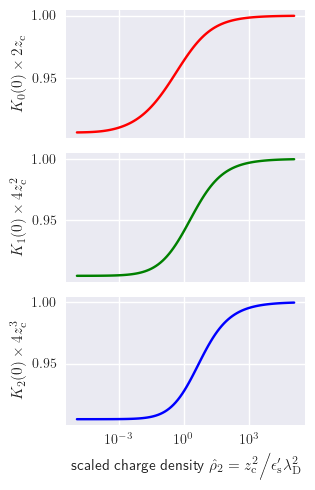

In [18]:
figs['01'] = plotKs(data)

<div class="alert alert-danger">
The different integrals have different half points!
</div>

For example, the half-point for the $K_0$ integral is near $\hat{\rho}_2 \sim 0.1$ whereas the half-point for the $K_2$ integral is near $\hat{\rho}_2 \sim 5$. 

# Plot the scaled $K_2$ integral at $\omega \rightarrow 0$ for various $\epsilon^{\prime}_{\mathrm{r}}$

Now set up an array of sample dielectric constants $\epsilon_{\mathrm{s}}$ to loop over.  Vary the real part of the dielectric constant from $3$ to $50$.  For simplicity, set the imaginary part of the dielectric constant to $0$.

In [19]:
epsilon_s__array = np.array([complex(3, 0), complex(5, 0), 
                             complex(10, 0), complex(20, 0), 
                             complex(30, 0), complex(50, 0)])

A function to loop over dielectric constant and, at each dielectric constant, loop over conductivity (and charge density).

In [20]:
def loop_epsilon_conductivity(sample1_jit, epsilon_s__array, sigma__array, rho__array):
    
    newdata = {}
    for index, epsilon_s_ in enumerate(epsilon_s__array):
        
        sample1_jit.epsilon_s = epsilon_s_
        newdata[index] = loop_conductivity(sample1_jit, sigma__array, rho__array)
        
    return newdata

In [21]:
newdata = loop_epsilon_conductivity(sample1_jit, epsilon_s__array, sigma__array, rho__array)

A function to plot the integral $K_2$ vs scaled charge density at the selected dielectric constants.

In [22]:
def plotKs_epsilon(epsilon_s__array, newdata):
    
    with plt.style.context('seaborn-v0_8'):

        fig = plt.figure(figsize=(3.50,3.25))
        
        for key, epsilon in zip(newdata.keys(), epsilon_s__array):
        
            plt.semilogx(newdata[key]['rho scaled 2'], 
                         newdata[key]['norm K2'],
                         label=epsilon.real)

        plt.ylabel(r'scaled integral $K_2(0) \times 4 z^3_{\mathrm{c}}$')
        plt.xlabel(
            r'scaled charge density $\hat{\rho}_2 = '
            r'z^2_{\mathrm{c}} \Big/ \epsilon^{\prime}_{\mathrm{s}} \lambda^2_{\mathrm{D}}$')
        plt.legend(fontsize=9, frameon=False, title=r'$\epsilon^{\prime}_{\mathrm{r}}$')
        fig.align_ylabels()
        plt.tight_layout()

    return fig

The figure takes a minute to generate using LaTeX.

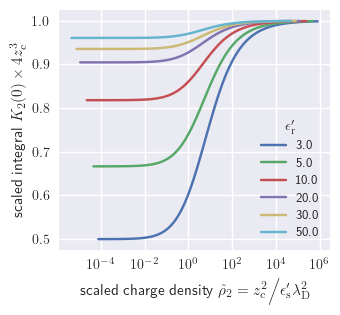

In [23]:
figs['02'] = plotKs_epsilon(epsilon_s__array, newdata)
figs['02']

<div class="alert alert-warning">
The charge-density half point for the $K_2$ integral depends on dielectric constant $\epsilon_{\mathrm{s}}$.
</div>

# Explore the midpoint

In Loring's notation, we can write the integral $K_2(\omega \rightarrow 0)$ as follows

\begin{equation}
K_2 = \frac{1}{4 z^3_{\mathrm{c}}}
  \left\{ \frac{\epsilon_{\mathrm{s}} - 1}{\epsilon_{\mathrm{s}} + 1} 
  + \frac{2}{\epsilon_{\mathrm{s}} + 1} f \right\}
\end{equation}

with

\begin{equation}
f = 4 \epsilon_{\mathrm{s}} 
  \int_{0}^{\infty} dy \: y^2 e^{- 2 y} 
    \frac{1 - \dfrac{y}{\sqrt{y^2 + \hat{\rho}_2}}}
         {\epsilon_{\mathrm{s}} + \dfrac{y}{\sqrt{y^2 + \hat{\rho}_2}}}
\end{equation}

a unitless function depending on the sample dielectric constant $\epsilon_{\mathrm{s}}$ and $\hat{\rho}_2 = z^2_{\mathrm{c}} \big/ \epsilon_{\mathrm{s}} \lambda^2_{\mathrm{D}}$ the scaled charge density.  At zero charge density, $\hat{\rho}_2 \rightarrow 0$, $f = 0$, and the integral becomes

\begin{equation}
K_2 \rightarrow \frac{1}{4 z^3_{\mathrm{c}}} 
  \frac{\epsilon_{\mathrm{s}} - 1}{\epsilon_{\mathrm{s}} + 1}
  \Longrightarrow
  K_2 \times 4 z^3_{\mathrm{c}} 
  = \frac{\epsilon_{\mathrm{s}} - 1}{\epsilon_{\mathrm{s}} + 1}
\end{equation}

At infinite charge density, $\hat{\rho}_2 \rightarrow \infty$, $f = 1$, and the integral becomes

\begin{equation}
K_2 \rightarrow \frac{1}{4 z^3_{\mathrm{c}}}
    \Longrightarrow
  K_2 \times 4 z^3_{\mathrm{c}} = 1
\end{equation}

When $f = 0.5$, the $K_2$ integral is halfway to its limiting value.  Below we determine numerically the value of the scaled charge density, $\hat{\rho}_2^\text{half}$, where this halfway-point occurs.  Based on the plot above, we expect that  $\hat{\rho}_2^\text{half}$ will depend weakly on $\epsilon_{\mathrm{s}}$.

Define the function $f$.  In the code below, `ep` represents $\epsilon_{\mathrm{s}}$ and `r` represents $\hat{\rho}_2$.

In [24]:
def f(y, ep, r):
    psi = y/np.sqrt(y**2 + r)
    return 4 * ep * y**2 * np.exp(-2*y) * (1 - psi)/(ep + psi)

Find the halfway point by hand for two values of the dielecric constant, 3 and 20.

In [25]:
r_half = 7.743 # adjust by hand
integrate.quad(f, 0., np.inf, args=(3.0, r_half))[0]

0.5000104107238752

In [26]:
r_half = 5.589 # adjust by hand
integrate.quad(f, 0., np.inf, args=(20.0, r_half))[0]

0.5000174637654241

We are looking for the value of `r_half` where `f` evaluates to 0.50.  This is equivalent to a root-finding problem.  Define a function `froot` which is just $f - 0.50$

In [27]:
def froot(r, ep):
    return -0.5 + integrate.quad(f, 0., np.inf, args=(ep, r))[0]

We can now use the `scipy.optimize` function `fsolve` to find where `froot = 0`, which is equivalent to finding where $f = 0.5$.  Use an initial guess of `r_half = 5.0`.

In [28]:
fsolve(froot, 5., args=(3.0))[0]

7.742478278622934

In [29]:
fsolve(froot, 5., args=(20.0))[0]

5.5883850237981205

Now find the `r_half` values using the `fsolve` function for $200$ dielectric constants ranging from $\epsilon_{\mathrm{s}} = 3$ to $\epsilon_{\mathrm{s}} = 100$.

In [30]:
ep_list = np.linspace(3, 100, 200)

r_half_list = np.zeros_like(ep_list)
for index, ep in enumerate(ep_list):
    r_half_list[index] = fsolve(froot, 5, args=(ep))[0]

Determine $\hat{\rho}_2^{\mathrm{half}}$ at selected values of $\epsilon_{\mathrm{s}}$.  In the printout below, the first column is $\epsilon_{\mathrm{s}}$ and the second column is $\hat{\rho}_2^{\mathrm{half}}$. 

In [31]:
for ep in [3, 10, 20, 100, 1000, 10000]:
    print("{:7.1f} {:0.3f}".format(ep, fsolve(froot, 5., args=(ep))[0]))

    3.0 7.742
   10.0 5.949
   20.0 5.588
  100.0 5.306
 1000.0 5.243
10000.0 5.237


So $\hat{\rho}_2^{\mathrm{half}}$ varies from 7.742 at $\epsilon_{\mathrm{s}} = 3$ to 5.306 at $\epsilon_{\mathrm{s}} = 100$.

A function to plot $\hat{\rho}_2^{\mathrm{half}}$ vs. $\epsilon_{\mathrm{s}}$ data computed above.

In [32]:
def plotrhalf(ep_list, r_half_list):
    
    with plt.style.context('seaborn-v0_8'):

        fig = plt.figure(figsize=(3.25,2.50))    
        plt.semilogx(ep_list, r_half_list)
        plt.grid(True, which="both")
        plt.xlabel(r'sample dielectric constant $\epsilon_{\mathrm{s}}$')
        plt.ylabel(r'half point $\hat{\rho}_2^{\mathrm{half}}$')
        plt.tight_layout()

    return fig

The half point is a weak function of the dielectric constant, so use a linear scale for the $y$ axis and a log scale for the $x$ axis.

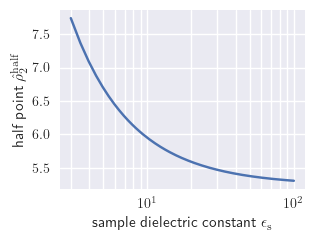

In [33]:
figs['03'] = plotrhalf(ep_list, r_half_list)
figs['03']

<div class="alert alert-warning">
The half point for the $K_2$ integral is only weakly dependent on the dielectric constant.
</div>

# Define a new scaled charge density $\hat{\rho}_3$ and replot $K_2$ vs. $\hat{\rho}_3$

Define a new scaled charge density given by 

\begin{equation}
\hat{\rho}_3 
  \equiv 
  \frac{z^2_{\mathrm{c}}}
       {7.742 \epsilon_{\mathrm{s}} \lambda^2_{\mathrm{D}}}
\end{equation}

where the numerical factor $7.742$ in the denominator was chosen so that $\hat{\rho}_3^{\mathrm{half}} = 1$ for a sample with $\epsilon_{\mathrm{s}} = 3$ (typical of an organic semiconductor).

In [34]:
def plotKs_epsilon_new(epsilon_s__array, newdata):
    
    with plt.style.context('seaborn-v0_8'):

        fig = plt.figure(figsize=(3.65,3.25))
        
        for key, epsilon in zip(newdata.keys(), epsilon_s__array):
        
            plt.semilogx(newdata[key]['rho scaled 3'], 
                         newdata[key]['norm K2'],
                         label=epsilon.real)

        plt.ylabel(r'scaled integral $K_2(0) \times 4 z^3_{\mathrm{c}}$')
        plt.xlabel(
            r'scaled charge density $\hat{\rho}_3 = '
            r'z^2_{\mathrm{c}} \Big/ 7.742 \, \epsilon^{\prime}_{\mathrm{s}} \lambda^2_{\mathrm{D}}$')
        plt.legend(fontsize=9, frameon=False, title=r'$\epsilon^{\prime}_{\mathrm{r}}$')
        plt.xlim(1e-6, 1e6)
        fig.align_ylabels()
        plt.tight_layout()

    return fig

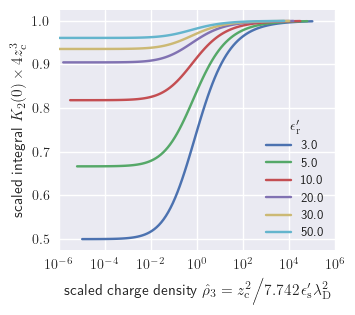

In [35]:
figs['04'] = plotKs_epsilon_new(epsilon_s__array, newdata)
figs['04']

<div class="alert alert-success">
We can define a new scaled charged density $\hat{\rho}_3$ such that the $K_2$ integral's half point is near $\hat{\rho}_3^{\mathrm{half}} = 1$ for $\epsilon_{\mathrm{r}} = 3$. The half point for dielectric constant $\epsilon_{\mathrm{r}} \geq 3$ will be $\hat{\rho}_3^{\mathrm{half}} \leq 1$.
</div>

# Save the figures

In [36]:
if 1:
    for num in figs.keys():
        figname = THIS + "Fig-" + num
        figs[num].savefig(figname + '.png', dpi=300)
        figs[num].savefig(figname + '.pdf')

::: {.content-hidden when-format="html"}

# Formatting notes

The header at the top of this file is for creating a nicely-formatted `.html` document using the program `quarto` ([link](https://quarto.org/)).  To create nicely-formated `.html`versions of this notebook, run `quarto` from the command line as follows

    quarto render dissipation-theory--Study-40.ipynb 

Other useful information about this notebook:

- Filename: `dissipation-theory--Study-40.ipynb`
- Continued from: `dissipation-theory--Study-39.ipynb`
- Continued to: ---

:::